In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
import json
import copy
import random

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('data/train.csv')
print(train.shape)
train.head()

(15248, 4)


,id,name,content,label
0,0,渠內有草,9月9日上午8点40分***村网格员***在辖区内巡查中当巡查到我村村北首时发现排水渠内长满...,0
1,1,清理楼道杂物,辖区内清理楼道杂物,0
2,2,路灯报修,2020年9月8日，***村网格员***，在三十八户村进行晚间摸排时，发现我们村村***大院...,0
3,3,商铺排查,2021年2月1日***第七网格员***在***小区内商铺排查有无安全隐患。,0
4,4,清理***4***北侧粪便,2020年9月7日8时10分***社区居委会***第一网格***，第二网格***，第三网格*...,0


<AxesSubplot:>

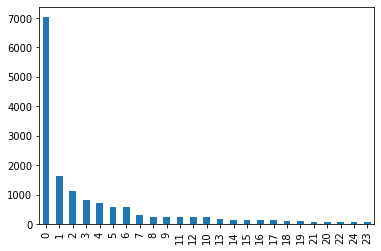

In [3]:
train.label.value_counts().plot.bar()

In [4]:
train[train.content.isna()]

,id,name,content,label
7149,7149,59号楼楼前乱扯乱晒,NaN,6
15232,15232,30号楼东侧垃圾箱满溢未处理,NaN,5


In [5]:
train['content'].fillna('', inplace=True)

train.content.apply(len).describe()

count    15248.000000
mean        69.849292
std         41.914151
min          0.000000
25%         40.000000
50%         68.000000
75%         91.000000
max        484.000000
Name: content, dtype: float64

In [6]:
train[train.name.isna()]

,id,name,content,label


In [7]:
train.name.apply(len).describe()

count    15248.000000
mean         9.254263
std          6.789092
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max        126.000000
Name: name, dtype: float64

In [8]:
test = pd.read_csv('data/testa_nolabel.csv')
print(test.shape)
test.head()

(5550, 3)


,id,name,content
0,0,清理玉米堆,9月9号在网格内巡查看到***门口处，主要路上有几堆玉米棒在路上堆着，对过往行人及车辆交通存...
1,1,***交通,2020年09月10日上午，***第一网格***，在日常走访巡查过程中，发现***村农贸市场...
2,2,***村前街路口西侧路南有杂草树枝等在路上，影响市容市貌和交通安全，需要清理干净。,2020.9.2日，***村前街路口西侧路南有杂草树枝等杂物，影响市容市容和交通安全，需清理干净。
3,3,共享单车乱停乱放,网格巡查时发现共享单车乱停乱放，影响市容
4,4,垃圾桶满,2020.09.03日上午巡查时，发现村东北角一处垃圾桶已满，已联系保洁员处理


In [9]:
test['content'].fillna('', inplace=True)

test.content.apply(len).describe()

count    5550.000000
mean       69.468108
std        41.847637
min         0.000000
25%        39.000000
50%        68.000000
75%        91.000000
max       482.000000
Name: content, dtype: float64

In [10]:
test.name.apply(len).describe()

count    5550.000000
mean        8.994234
std         6.391727
min         1.000000
25%         5.000000
50%         7.000000
75%        11.000000
max       126.000000
Name: name, dtype: float64

In [11]:
def concat_text(row):
    return f'事件简述:{row["name"]}[SEP]'\
           f'事件内容:{row["content"]}'

train['text'] = train.apply(lambda row: concat_text(row), axis=1)

In [12]:
n_splits = 5
seed = 42
folds = {}
count = 0

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
for trn_idx, val_idx in kfold.split(train['text'], train['label']):
    folds['fold_{}'.format(count)] = {}
    folds['fold_{}'.format(count)]['train'] = trn_idx.tolist()
    folds['fold_{}'.format(count)]['valid'] = val_idx.tolist()
    count += 1
    
with open('folds.json', 'w') as fp:
    json.dump(folds, fp)

In [13]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup, AutoConfig

In [14]:
SEED = 42
NUM_CLASSES = train['label'].nunique()

In [15]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = SEED
        self.MODEL_PATH = 'hfl/chinese-roberta-wwm-ext'
        self.NUM_LABELS = NUM_CLASSES

        # data
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 16

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 2
        
config = Config()

In [16]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


np.random.seed(config.SEED)
seed_torch(seed=config.SEED)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [17]:
train_df = train[['text', 'label']]
print(train_df.shape)
train_df.head()

(15248, 2)


,text,label
0,事件简述:渠內有草[SEP]事件内容:9月9日上午8点40分***村网格员***在辖区内巡查...,0
1,事件简述:清理楼道杂物[SEP]事件内容:辖区内清理楼道杂物,0
2,事件简述:路灯报修[SEP]事件内容:2020年9月8日，***村网格员***，在三十八户村...,0
3,事件简述:商铺排查[SEP]事件内容:2021年2月1日***第七网格员***在***小区内...,0
4,事件简述:清理***4***北侧粪便[SEP]事件内容:2020年9月7日8时10分***社...,0


In [18]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, set_type='train'):
        super(TransformerDataset, self).__init__()

        df = data.iloc[indices]
        self.texts = df['text'].values.tolist()
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = df['label'].values.tolist()

        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.tensor(self.labels[index], dtype=torch.long)
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [19]:
with open('folds.json') as f:
    kfolds = json.load(f)

FOLD = 0

train_indices = kfolds[f'fold_{FOLD}']['train']
valid_indices = kfolds[f'fold_{FOLD}']['valid']

train_data = TransformerDataset(train_df, train_indices)
valid_data = TransformerDataset(train_df, valid_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=config.BATCH_SIZE, shuffle=False)

In [20]:
b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 256])
attention_mask shape: torch.Size([16, 256])
labels shape: torch.Size([16])


In [21]:
class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(config.MODEL_PATH)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.bert.config.hidden_size, NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [22]:
def val_fn(model, valid_dataloader, criterion):
    val_loss = 0
    corrects = 0
    model.eval()
    for step, batch in enumerate(valid_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            loss = criterion(logits, b_labels)
            val_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            corrects += torch.sum(preds == b_labels)
    avg_val_loss = val_loss / len(valid_dataloader)
    avg_val_acc = corrects.cpu().numpy() / len(valid_dataloader) / config.BATCH_SIZE
    print('Val loss:', avg_val_loss, 'Val acc:', avg_val_acc)
    return avg_val_loss, avg_val_acc

In [23]:
def train_fn(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, epoch):
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    corrects = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        loss = criterion(logits, b_labels)
        train_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        corrects += torch.sum(preds == b_labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val_fn(model, valid_dataloader, criterion)

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_acc = corrects.cpu().numpy() / len(train_dataloader) / config.BATCH_SIZE
    
    print('Training loss:', avg_train_loss, 'Training acc:', avg_train_acc)

In [24]:
def run():
    torch.manual_seed(config.SEED)
    criterion = nn.CrossEntropyLoss()

    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    min_avg_val_loss = float('inf')
    for epoch in range(config.EPOCHS):
        train_fn(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, epoch)
        avg_val_loss, avg_val_acc = val_fn(model, valid_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if avg_val_loss < min_avg_val_loss:
                best_model = copy.deepcopy(model)
                best_val_loss = avg_val_loss

                model_name = f'model_{FOLD}'
                torch.save(best_model.state_dict(), 'models/' + model_name + '.pt')

                print(f'--- Best Model. Val loss: {min_avg_val_loss} -> {avg_val_loss}')
                min_avg_val_loss = avg_val_loss

    return best_model, best_val_loss

In [25]:
device = config.DEVICE

model = BERTClassifier()
model.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [26]:
best_model, best_val_loss = run()

-- Step: 200
Val loss: 1.511189848652685 Val acc: 0.5723167539267016
-- Step: 400
Val loss: 1.2617869199258496 Val acc: 0.6119109947643979
-- Step: 600
Val loss: 1.1829807616341177 Val acc: 0.6341623036649214

Training loss: 1.4217884927636517 Training acc: 0.5876474442988204
Val loss: 1.16085235142583 Val acc: 0.6341623036649214
--- Best Model. Val loss: inf -> 1.16085235142583


-- Step: 200
Val loss: 1.120378705843581 Val acc: 0.6524869109947644
-- Step: 400
Val loss: 1.103209250260398 Val acc: 0.6560863874345549
-- Step: 600
Val loss: 1.0831237951810446 Val acc: 0.6645942408376964

Training loss: 1.0138599579253016 Training acc: 0.6810288335517694
Val loss: 1.071185555289553 Val acc: 0.6675392670157068
--- Best Model. Val loss: 1.16085235142583 -> 1.071185555289553


In [28]:
test['text'] = test.apply(lambda row: concat_text(row), axis=1)
test_df = test[['id', 'text']]
print(test_df.shape)
test_df.head()

(5550, 2)


,id,text
0,0,事件简述:清理玉米堆[SEP]事件内容:9月9号在网格内巡查看到***门口处，主要路上有几堆...
1,1,事件简述:***交通[SEP]事件内容:2020年09月10日上午，***第一网格***，在...
2,2,事件简述:***村前街路口西侧路南有杂草树枝等在路上，影响市容市貌和交通安全，需要清理干净。...
3,3,事件简述:共享单车乱停乱放[SEP]事件内容:网格巡查时发现共享单车乱停乱放，影响市容
4,4,事件简述:垃圾桶满[SEP]事件内容:2020.09.03日上午巡查时，发现村东北角一处垃圾...


In [29]:
test_indices = list(range(len(test_df)))
test_data = TransformerDataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

In [30]:
def predict(model):
    test_pred = []
    model.eval()
    for step, batch in enumerate(test_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            _, preds = torch.max(logits, dim=1)
            preds = preds.cpu().numpy()
            test_pred.extend(preds)
    test_pred = np.array(test_pred)
    return test_pred

In [31]:
test_pred = predict(best_model)

In [33]:
test_df['label'] = test_pred
test_df.head()

,id,text,label
0,0,事件简述:清理玉米堆[SEP]事件内容:9月9号在网格内巡查看到***门口处，主要路上有几堆...,1
1,1,事件简述:***交通[SEP]事件内容:2020年09月10日上午，***第一网格***，在...,2
2,2,事件简述:***村前街路口西侧路南有杂草树枝等在路上，影响市容市貌和交通安全，需要清理干净。...,0
3,3,事件简述:共享单车乱停乱放[SEP]事件内容:网格巡查时发现共享单车乱停乱放，影响市容,2
4,4,事件简述:垃圾桶满[SEP]事件内容:2020.09.03日上午巡查时，发现村东北角一处垃圾...,0


In [36]:
test_df[['id', 'label']].to_csv('roberta_baseline.csv', index=False)